### plot_time_course

In [22]:
#!/usr/bin/env python3
# coding: utf-8

import os, re, sys
import glob, json
import argparse

import numpy as np
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns

from pctk import multicellds 

# import re, os, sys
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from pctk import multicellds 


# modules_path = "../"
# modules_path = os.path.dirname(os.path.realpath(__file__))
# modules_path= os.path.join(modules_path, 'scripts/')
# modules_path= os.path.join(modules_path, 'modules')
# sys.path.append(modules_path)

sns.set(style="ticks", palette="Paired")
sns.set_context('paper')

def create_parser():
    parser = argparse.ArgumentParser(description="Plot total cell grouped as Alive/Necrotic/Apoptotic vs Time")
    
    parser.add_argument("data_folder", action="store", help="folder were the data is stored")
    
    parser.add_argument("--format", action="store", dest="format", choices=("physicell", "physiboss"),
                        help="Format of the input data", default="physicell")

    parser.add_argument("--figout", action="store", dest="fig_fname", default="./cell_vs_time.png",
                        help="File name to save the plot")
                        
    parser.add_argument("--csvout", action="store", dest="csv_fname", default=None,
                        help="File name to store the summary table used for the plot")

    return parser
    
def pb_output_iterator(data_folder, sep=";"):
    globing = os.path.join(data_folder, "cells_[0-9]*.txt")
    for fname in sorted(glob.glob(globing)):
        df = pd.read_csv(fname, sep=sep)
        t = df.Time[0]
        yield (t, df)

def count_pb_files(data_folder):
    globing = os.path.join(data_folder, "cells_[0-9]*.txt")
    return len(glob.glob(globing))

In [23]:
def get_timeserie_mean(mcds, filter_alive=True):
    time = []
    values = []
    filter_alive = True
    for t, df in mcds.cells_as_frames_iterator():
        time.append(t)
        df = df.iloc[:,3:]
        if filter_alive:
            mask = df['current_phase'] <= 14
            df = df[mask]
        values.append(df.mean(axis=0).values)
        # if filter_alive:
        #     # Fix: Use boolean indexing properly
        #     mask = (df['current_phase'].astype(float) <= 14).values  # Convert to numeric and create boolean mask
        #     df = df[mask]
        # if len(df) > 0:  # Check if any cells remain after filtering
        #     values.append(df.mean(axis=0).values)
        # else:
        #     # Handle empty dataframe case
        #     empty_values = np.zeros(len(df.columns))
        #     values.append(empty_values)

    cell_columns = df.columns.tolist()
    df = pd.DataFrame(values, columns=cell_columns)
    df['time'] = time
    return df[['time'] + cell_columns]


def get_timeserie_density(mcds):
    data = []
    for t,m in mcds.microenvironment_as_matrix_iterator():
        data.append((t, m[5,:].sum()))
    df = pd.DataFrame(data=data, columns=['time', 'drug_A_internal_density'])
    return df

def plot_molecular_model(df_cell_variables, list_of_variables, ax1):

    threshold = 0.5

    for label in list_of_variables:
        y = df_cell_variables[label]
        time = df_cell_variables["time"]
        ax1.plot(time, y, label= label)

    ax1.set_ylabel("Quantity")
    ax1.yaxis.grid(True)
    # ax1.set_xlim((0,time.values[-1]))
    # ax1.set_ylim((0,1))
    # ax1.set_xlabel("time (min)")
    
def plot_cells(df_time_course, color_dict, ax):

    # Alive/Apoptotic/Necrotic vs Time
    for k in color_dict:
        axes[0].plot(df_time_course.time, df_time_course[k], "-", c=color_dict[k], label=k)
    
    # setting axes labels
    # axes[0].set_xlabel("time (min)")
    ax.set_ylabel("Number of cells")
    
    # Showing legend
    ax.legend()
    ax.yaxis.grid(True)

{0: 'Ki67_positive_premitotic', 1: 'Ki67_positive_postmitotic', 2: 'Ki67_positive', 3: 'Ki67_negative', 4: 'G0G1_phase', 5: 'G0_phase', 6: 'G1_phase', 7: 'G1a_phase', 8: 'G1b_phase', 9: 'G1c_phase', 10: 'S_phase', 11: 'G2M_phase', 12: 'G2_phase', 13: 'M_phase', 14: 'live', 100: 'apoptotic', 101: 'necrotic_swelling', 102: 'necrotic_lysed', 103: 'necrotic', 104: 'debris'}
{'Ki67_positive_premitotic': 'alive', 'Ki67_positive_postmitotic': 'alive', 'Ki67_positive': 'alive', 'Ki67_negative': 'alive', 'G0G1_phase': 'alive', 'G0_phase': 'alive', 'G1_phase': 'alive', 'G1a_phase': 'alive', 'G1b_phase': 'alive', 'G1c_phase': 'alive', 'S_phase': 'alive', 'G2M_phase': 'alive', 'G2_phase': 'alive', 'M_phase': 'alive', 'live': 'alive', 'apoptotic': 'apoptotic', 'necrotic_lysed': 'necrotic', 'necrotic_swelling': 'necrotic'}
	Processing time step: 0
	Processing time step: 15
	Processing time step: 30
	Processing time step: 45
	Processing time step: 60
	Processing time step: 75
	Processing time step: 9

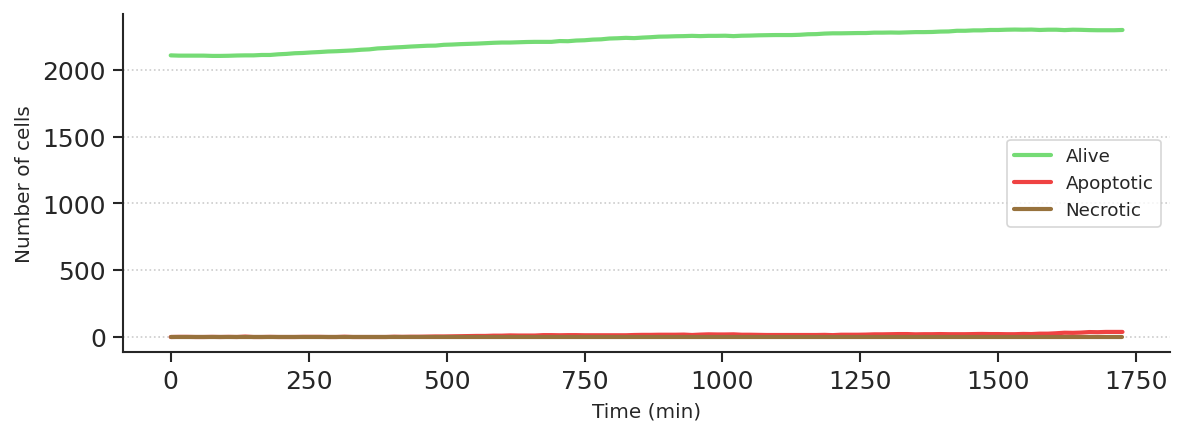

In [24]:
# parser = create_parser()
# args = parser.parse_args()
name = "PhysiCell/output_APN"
data_folder = f"../../{name}"
# print (data_folder)
fig_fname  = name
csv_fname = name

phases_dict = multicellds.default_phases_dict
phase_grouping = multicellds.default_phase_grouping
print(phases_dict)
print(phase_grouping)

# Globing output files according to the output format specified
# if args.format == 'physicell':
phase_col = "current_phase"
mcds = multicellds.MultiCellDS(output_folder=data_folder)
df_iterator = mcds.cells_as_frames_iterator()
num_of_files = mcds.cells_file_count()
# elif args.format == 'physiboss':
#     phase_col = "phase"
#     df_iterator = pb_output_iterator(args.data_folder)
#     num_of_files = count_pb_files(args.data_folder)

# Initializing a Pandas Databrafe to store the data
columns = ["time", "alive", "apoptotic", "necrotic"]
data = np.zeros((num_of_files, 4), dtype=int)
df_time_course = pd.DataFrame(columns=columns, data=data)

# print("Reading cell_output files from %i input files from %s" % (num_of_files, data_folder))
# Iterating over all cell_output files
for i, (t, df) in enumerate(df_iterator):
    print("\tProcessing time step: %.0f" % t)

    # Rename the phases integer codes using the phases_dict as the mapping
    s = df[phase_col]
    s.replace(to_replace=phases_dict, inplace=True)
    
    # Count the number of cells in each phase
    counts = s.value_counts()

    df_time_course.loc[i, 'time'] = t
    # group the previous phases count into the three general classes:
    # Alive, Apoptotic, Necrotic
    for k, v in counts.to_dict().items():
        if k not in phase_grouping:
            continue
        df_time_course.loc[i, phase_grouping[k]] += v
        
        # print("Finish processing files")    
# Set time column as the dataframe index
sns.set_context('paper')
patch_color = "lightgrey"

# print("Creating figure")
# Create a figure
# fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=300)
fig, axes = plt.subplots(1, 1, figsize=(8,3), dpi=150, sharex=True)

# plot Alive vs Time
curve_params = {}
curve_params['alive'] = {'color': '#75db75', 'label': 'Alive'}
curve_params['apoptotic'] = {'color': '#ef4242', 'label': 'Apoptotic'}
curve_params['necrotic'] = {'color':'#97723d', 'label': 'Necrotic'}
line_width = 2.
for k,pdict in curve_params.items():
    c = pdict['color']
    l = pdict['label']
    axes.plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

# setting axes labels
axes.set_xlabel("Time (min)")
axes.set_ylabel("Number of cells")

axes.tick_params(axis='x', labelsize=12)
axes.tick_params(axis='y', labelsize=12)

# Showing legend
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.yaxis.grid(linestyle='dotted')
axes.legend()
# color_dict = {"alive": "g", "apoptotic": "r", "necrotic":"k"}
fig.tight_layout()

{0: 'default', 1: 'Epithelial', 2: 'immune', 3: 'CD8 Tcell', 4: 'macrophage', 5: 'neutrophil', 6: 'DC', 7: 'CD4 Tcell', 8: 'fibroblast'}
{'default': 'default', 'Epithelial': 'Epithelial', 'immune': 'immune', 'CD8 Tcell': 'CD8 Tcell', 'macrophage': 'macrophage', 'neutrophil': 'neutrophil', 'DC': 'DC', 'CD4 Tcell': 'CD4 Tcell', 'fibroblast': 'fibroblast'}
	Processing time step: 0
	Processing time step: 15
	Processing time step: 30
	Processing time step: 45
	Processing time step: 60
	Processing time step: 75
	Processing time step: 90
	Processing time step: 105
	Processing time step: 120
	Processing time step: 135
	Processing time step: 150
	Processing time step: 165
	Processing time step: 180
	Processing time step: 195
	Processing time step: 210
	Processing time step: 225
	Processing time step: 240
	Processing time step: 255
	Processing time step: 270
	Processing time step: 285
	Processing time step: 300
	Processing time step: 315
	Processing time step: 330
	Processing time step: 345
	Pro

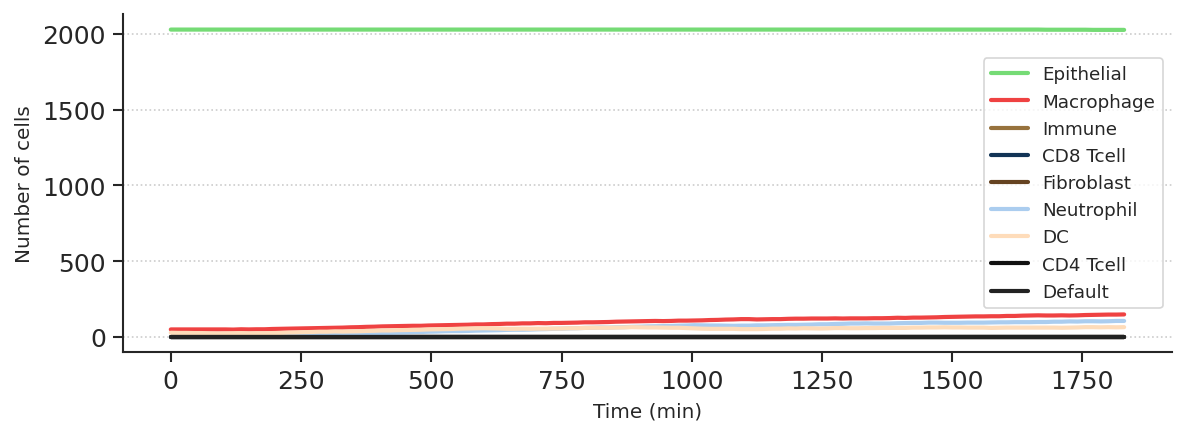

In [31]:
covid_type_dict = {
    0: "default",
    1: "Epithelial",
    2: "immune",
    3: "CD8 Tcell",
    4: "macrophage",
    5: "neutrophil",
    6: "DC",
    7: "CD4 Tcell",
    8: "fibroblast"    
    }

covid_type_grouping = {
    "default": "default",
    "Epithelial": "Epithelial",
    "immune": "immune",
    "CD8 Tcell": "CD8 Tcell",
    "macrophage": "macrophage",
    "neutrophil": "neutrophil",
    "DC": "DC",
    "CD4 Tcell": "CD4 Tcell",
    "fibroblast": "fibroblast"
    }

# parser = create_parser()
# args = parser.parse_args()
name = "PhysiCell/output_APN"
data_folder = f"../../{name}"
# print (data_folder)
fig_fname  = name
csv_fname = name

phases_dict = covid_type_dict
phase_grouping = covid_type_grouping
print(phases_dict)
print(phase_grouping)

# Globing output files according to the output format specified
# if args.format == 'physicell':
phase_col = "cell_type"
mcds = multicellds.MultiCellDS(output_folder=data_folder)
df_iterator = mcds.cells_as_frames_iterator()
num_of_files = mcds.cells_file_count()

columns = ["Epithelial", "immune", "CD8 Tcell", "macrophage", "neutrophil", "DC", "CD4 Tcell", "fibroblast","default"]
data = np.zeros((num_of_files, 9), dtype=int)
df_time_course = pd.DataFrame(columns=columns, data=data)

for i, (t, df) in enumerate(df_iterator):
    print("\tProcessing time step: %.0f" % t)

    # Rename the phases integer codes using the phases_dict as the mapping
    s = df[phase_col]
    s.replace(to_replace=phases_dict, inplace=True)
    
    # Count the number of cells in each phase
    counts = s.value_counts()

    df_time_course.loc[i, 'time'] = t
    # group the previous phases count into the three general classes:
    # Alive, Apoptotic, Necrotic
    for k, v in counts.to_dict().items():
        if k not in phase_grouping:
            continue
        df_time_course.loc[i, phase_grouping[k]] += v
        

sns.set_context('paper')
patch_color = "lightgrey"

fig, axes = plt.subplots(1, 1, figsize=(8,3), dpi=150, sharex=True)

# plot Alive vs Time
curve_params = {}
curve_params['Epithelial'] = {'color': '#75db75', 'label': 'Epithelial'}
curve_params['macrophage'] = {'color': '#ef4242', 'label': 'Macrophage'}
curve_params['immune'] = {'color':'#97723d', 'label': 'Immune'}
curve_params['CD8 Tcell'] = {'color':'#123456', 'label': 'CD8 Tcell'}
curve_params['fibroblast'] = {'color':'#654321', 'label': 'Fibroblast'}
curve_params['neutrophil'] = {'color':'#abcdef', 'label': 'Neutrophil'}
curve_params['DC'] = {'color':'#fedcba', 'label': 'DC'}
curve_params['CD4 Tcell'] = {'color':'#111111', 'label': 'CD4 Tcell'}
curve_params['default'] = {'color':'#222222', 'label': 'Default'}
line_width = 2.
for k,pdict in curve_params.items():
    c = pdict['color']
    l = pdict['label']
    axes.plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

# setting axes labels
axes.set_xlabel("Time (min)")
axes.set_ylabel("Number of cells")

axes.tick_params(axis='x', labelsize=12)
axes.tick_params(axis='y', labelsize=12)

# Showing legend
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.yaxis.grid(linestyle='dotted')
axes.legend()
fig.tight_layout()

{0: 'Ki67_positive_premitotic', 1: 'Ki67_positive_postmitotic', 2: 'Ki67_positive', 3: 'Ki67_negative', 4: 'G0G1_phase', 5: 'G0_phase', 6: 'G1_phase', 7: 'G1a_phase', 8: 'G1b_phase', 9: 'G1c_phase', 10: 'S_phase', 11: 'G2M_phase', 12: 'G2_phase', 13: 'M_phase', 14: 'live', 100: 'apoptotic', 101: 'necrotic_swelling', 102: 'necrotic_lysed', 103: 'necrotic', 104: 'debris'}
{'Ki67_positive_premitotic': 'alive', 'Ki67_positive_postmitotic': 'alive', 'Ki67_positive': 'alive', 'Ki67_negative': 'alive', 'G0G1_phase': 'alive', 'G0_phase': 'alive', 'G1_phase': 'alive', 'G1a_phase': 'alive', 'G1b_phase': 'alive', 'G1c_phase': 'alive', 'S_phase': 'alive', 'G2M_phase': 'alive', 'G2_phase': 'alive', 'M_phase': 'alive', 'live': 'alive', 'apoptotic': 'apoptotic', 'necrotic_lysed': 'necrotic', 'necrotic_swelling': 'necrotic'}
	Processing time step: 0
	Processing time step: 60
	Processing time step: 120
	Processing time step: 180
	Processing time step: 240
	Processing time step: 300
	Processing time ste

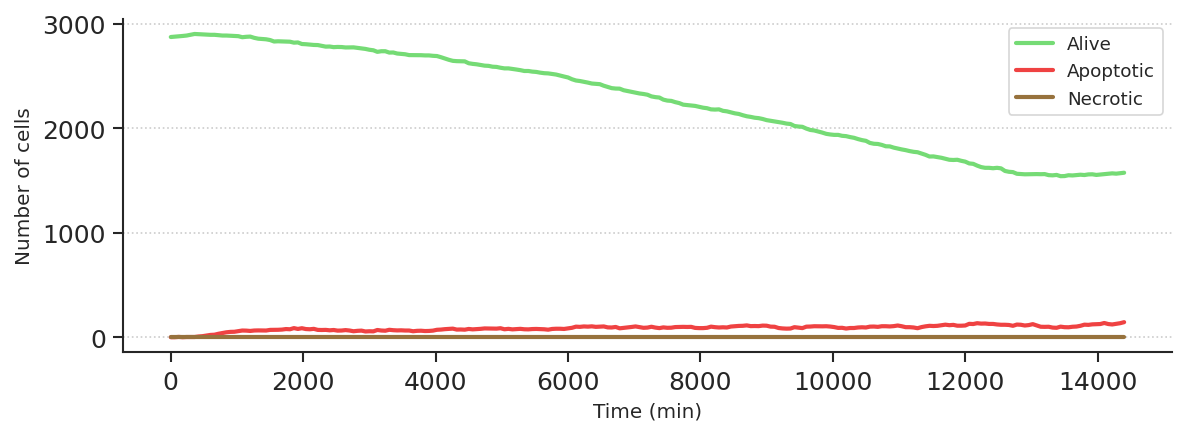

In [26]:
name = "PhysiCell_ori/output_C141"
data_folder = f"../../{name}"
# print (data_folder)
fig_fname  = name
csv_fname = name

phases_dict = multicellds.default_phases_dict
phase_grouping = multicellds.default_phase_grouping
print(phases_dict)
print(phase_grouping)

phase_col = "current_phase"
mcds = multicellds.MultiCellDS(output_folder=data_folder)
df_iterator = mcds.cells_as_frames_iterator()
num_of_files = mcds.cells_file_count()

columns = ["time", "alive", "apoptotic", "necrotic"]
data = np.zeros((num_of_files, 4), dtype=int)
df_time_course = pd.DataFrame(columns=columns, data=data)

for i, (t, df) in enumerate(df_iterator):
    print("\tProcessing time step: %.0f" % t)

    # Rename the phases integer codes using the phases_dict as the mapping
    s = df[phase_col]
    s.replace(to_replace=phases_dict, inplace=True)
    
    # Count the number of cells in each phase
    counts = s.value_counts()

    df_time_course.loc[i, 'time'] = t
    # group the previous phases count into the three general classes:
    # Alive, Apoptotic, Necrotic
    for k, v in counts.to_dict().items():
        if k not in phase_grouping:
            continue
        df_time_course.loc[i, phase_grouping[k]] += v

       # print("Finish processing files")

sns.set_context('paper')
patch_color = "lightgrey"

# print("Creating figure")
# Create a figure
# fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=300)
fig, axes = plt.subplots(1, 1, figsize=(8,3), dpi=150, sharex=True)

# plot Alive vs Time
curve_params = {}
curve_params['alive'] = {'color': '#75db75', 'label': 'Alive'}
curve_params['apoptotic'] = {'color': '#ef4242', 'label': 'Apoptotic'}
curve_params['necrotic'] = {'color':'#97723d', 'label': 'Necrotic'}
line_width = 2.
for k,pdict in curve_params.items():
    c = pdict['color']
    l = pdict['label']
    axes.plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

# setting axes labels
axes.set_xlabel("Time (min)")
axes.set_ylabel("Number of cells")

axes.tick_params(axis='x', labelsize=12)
axes.tick_params(axis='y', labelsize=12)

# Showing legend
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.yaxis.grid(linestyle='dotted')
axes.legend()
# color_dict = {"alive": "g", "apoptotic": "r", "necrotic":"k"}
fig.tight_layout()

{0: 'default', 1: 'Epithelial', 2: 'immune', 3: 'CD8 Tcell', 4: 'macrophage', 5: 'neutrophil', 6: 'DC', 7: 'CD4 Tcell', 8: 'fibroblast'}
{'default': 'default', 'Epithelial': 'Epithelial', 'immune': 'immune', 'CD8 Tcell': 'CD8 Tcell', 'macrophage': 'macrophage', 'neutrophil': 'neutrophil', 'DC': 'DC', 'CD4 Tcell': 'CD4 Tcell', 'fibroblast': 'fibroblast'}
	Processing time step: 0
	Processing time step: 60
	Processing time step: 120
	Processing time step: 180
	Processing time step: 240
	Processing time step: 300
	Processing time step: 360
	Processing time step: 420
	Processing time step: 480
	Processing time step: 540
	Processing time step: 600
	Processing time step: 660
	Processing time step: 720
	Processing time step: 780
	Processing time step: 840
	Processing time step: 900
	Processing time step: 960
	Processing time step: 1020
	Processing time step: 1080
	Processing time step: 1140
	Processing time step: 1200
	Processing time step: 1260
	Processing time step: 1320
	Processing time ste

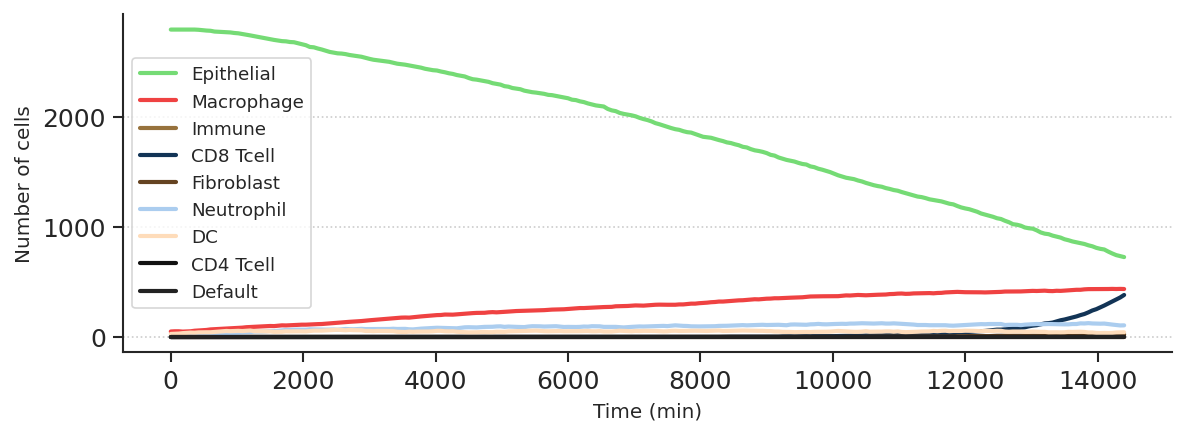

In [32]:
covid_type_dict = {
    0: "default",
    1: "Epithelial",
    2: "immune",
    3: "CD8 Tcell",
    4: "macrophage",
    5: "neutrophil",
    6: "DC",
    7: "CD4 Tcell",
    8: "fibroblast"    
    }

covid_type_grouping = {
    "default": "default",
    "Epithelial": "Epithelial",
    "immune": "immune",
    "CD8 Tcell": "CD8 Tcell",
    "macrophage": "macrophage",
    "neutrophil": "neutrophil",
    "DC": "DC",
    "CD4 Tcell": "CD4 Tcell",
    "fibroblast": "fibroblast"
    }

# parser = create_parser()
# args = parser.parse_args()
name = "PhysiCell_ori/output_C141"
data_folder = f"../../{name}"
# print (data_folder)
fig_fname  = name
csv_fname = name

phases_dict = covid_type_dict
phase_grouping = covid_type_grouping
print(phases_dict)
print(phase_grouping)

# Globing output files according to the output format specified
# if args.format == 'physicell':
phase_col = "cell_type"
mcds = multicellds.MultiCellDS(output_folder=data_folder)
df_iterator = mcds.cells_as_frames_iterator()
num_of_files = mcds.cells_file_count()

columns = ["Epithelial", "immune", "CD8 Tcell", "macrophage", "neutrophil", "DC", "CD4 Tcell", "fibroblast","default"]
data = np.zeros((num_of_files, 9), dtype=int)
df_time_course = pd.DataFrame(columns=columns, data=data)

for i, (t, df) in enumerate(df_iterator):
    print("\tProcessing time step: %.0f" % t)

    # Rename the phases integer codes using the phases_dict as the mapping
    s = df[phase_col]
    s.replace(to_replace=phases_dict, inplace=True)
    
    # Count the number of cells in each phase
    counts = s.value_counts()

    df_time_course.loc[i, 'time'] = t
    # group the previous phases count into the three general classes:
    # Alive, Apoptotic, Necrotic
    for k, v in counts.to_dict().items():
        if k not in phase_grouping:
            continue
        df_time_course.loc[i, phase_grouping[k]] += v
        

sns.set_context('paper')
patch_color = "lightgrey"

fig, axes = plt.subplots(1, 1, figsize=(8,3), dpi=150, sharex=True)

# plot Alive vs Time
curve_params = {}
curve_params['Epithelial'] = {'color': '#75db75', 'label': 'Epithelial'}
curve_params['macrophage'] = {'color': '#ef4242', 'label': 'Macrophage'}
curve_params['immune'] = {'color':'#97723d', 'label': 'Immune'}
curve_params['CD8 Tcell'] = {'color':'#123456', 'label': 'CD8 Tcell'}
curve_params['fibroblast'] = {'color':'#654321', 'label': 'Fibroblast'}
curve_params['neutrophil'] = {'color':'#abcdef', 'label': 'Neutrophil'}
curve_params['DC'] = {'color':'#fedcba', 'label': 'DC'}
curve_params['CD4 Tcell'] = {'color':'#111111', 'label': 'CD4 Tcell'}
curve_params['default'] = {'color':'#222222', 'label': 'Default'}
line_width = 2.
for k,pdict in curve_params.items():
    c = pdict['color']
    l = pdict['label']
    axes.plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

# setting axes labels
axes.set_xlabel("Time (min)")
axes.set_ylabel("Number of cells")

axes.tick_params(axis='x', labelsize=12)
axes.tick_params(axis='y', labelsize=12)

# Showing legend
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.yaxis.grid(linestyle='dotted')
axes.legend()
fig.tight_layout()

In [27]:
# # print("Finish processing files")    
# # Set time column as the dataframe index
# sns.set_context('paper')
# patch_color = "lightgrey"

# # print("Creating figure")
# # Create a figure
# # fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=300)
# fig, axes = plt.subplots(3, 1, figsize=(12,12), dpi=150, sharex=True)

# # plot Alive vs Time
# curve_params = {}
# curve_params['alive'] = {'color': '#75db75', 'label': 'Alive'}
# curve_params['apoptotic'] = {'color': '#ef4242', 'label': 'Apoptotic'}
# curve_params['necrotic'] = {'color':'#97723d', 'label': 'Necrotic'}
# line_width = 2.
# for k,pdict in curve_params.items():
#     c = pdict['color']
#     l = pdict['label']
#     axes[0].plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

# # setting axes labels
# axes[0].set_xlabel("Time (min)")
# axes[0].set_ylabel("Number of cells")

# axes[0].tick_params(axis='x', labelsize=12)
# axes[0].tick_params(axis='y', labelsize=12)

# # Showing legend
# axes[0].spines['right'].set_visible(False)
# axes[0].spines['top'].set_visible(False)
# axes[0].yaxis.grid(linestyle='dotted')
# axes[0].legend()

# # fig.tight_layout()
# # fig.savefig(fig_fname)
# # print("Saving fig as %s" % fig_fname)

# # if csv_fname:
# #     df_time_course.to_csv(csv_fname+".csv", sep="\t")
# #     print("Saving csv as %s" % csv_fname)

# # name = "output"

# color_dict = {"alive": "g", "apoptotic": "r", "necrotic":"k"}

# # instance_folder = "../../../../"
# # instance_folder = sys.argv[1]

# output_data = data_folder

# mcds = multicellds.MultiCellDS(output_folder=output_data)

# # df_time_course = mcds.get_cells_summary_frame()
# df_cell_variables = get_timeserie_mean(mcds)
# df_time_tnf = get_timeserie_density(mcds)

# # df_time_course.to_csv(instance_folder + name + "_time_course.tsv", sep="\t")
# # df_cell_variables.to_csv(instance_folder + name + "_cell_variables.tsv", sep="\t")
# # df_time_tnf.to_csv(instance_folder + name + "_tnf_time.tsv", sep="\t")

# # plot_cells(df_time_course, color_dict, axes[0])

# list_of_variables = ['drug_A_internal_density', 'drug_A_external_density']
# plot_molecular_model(df_cell_variables, list_of_variables, axes[1])
# # threshold = 0.5

# # axes[1].hlines(threshold, 0, df_time_course.time.iloc[-1], label="Activation threshold")
# ax2 = axes[1].twinx()
# ax2.plot(df_time_tnf.time, df_time_tnf['drug_A_internal_density'], 'r', label="[drug_A]")
# # ax2.set_ylabel("[TNF]")
# # ax2.set_ylim([0, 1000])
# axes[1].legend(loc="center right")
# ax2.legend(loc="upper right")

# # list_of_variables = ['Proliferation_node', 'Apoptosis_node', 'TNFalpha_node']
# # plot_molecular_model(df_cell_variables, list_of_variables, axes[2])
# # axes[2].set_xlabel("time (min)")
# # axes[2].set_ylabel("Node mean activation")
# # ax2 = axes[2].twinx()
# # ax2.plot(df_time_tnf.time, df_time_tnf['drug_A_internal_density'], 'r', label="[drug_A]")
# # axes[2].legend(loc="center right")
# # ax2.legend(loc="upper right")

# fig.tight_layout()

In [28]:
# # fig, ax1 = plt.subplots(1, 1, figsize=(8,3), dpi=300)

# list_of_variables = ['time','Proliferation_node', 'Apoptosis_node', 'TNFalpha_node']

# df_nodes = df_cell_variables[list_of_variables]

# fig, ax = plt.subplots(figsize=(10,6))

# # Plot each node variable vs time
# a = 0
# for col in list_of_variables[1:]:  # Skip 'time' column
#     ax.plot(df_nodes['time'], df_nodes[col], label=col.replace('_node', ''))
#     a=a+1


# # Customize plot
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Node Activation')
# ax.set_title('Boolean Node States Over Time')
# ax.grid(True, linestyle='--', alpha=0.7)
# ax.legend(loc='center right')
# plt.tight_layout()
# plt.show()


In [29]:
# def plot_columns_by_name(df, column_names, title=None, figsize=(10,6), ylabel="Value"):
#     """
#     Plot selected columns from a DataFrame
    
#     Args:
#         df (pandas.DataFrame): DataFrame containing the data
#         column_names (list): List of column names to plot
#         title (str, optional): Plot title
#         figsize (tuple, optional): Figure size (width, height)
#         ylabel (str, optional): Y-axis label
#     """
#     fig, ax = plt.subplots(figsize=figsize)
    
#     for col in column_names:
#         if col in df.columns:
#             ax.plot(df['time'], df[col], label=col)
#         else:
#             print(f"Warning: Column '{col}' not found in DataFrame")
    
#     ax.set_xlabel("Time (min)")
#     ax.set_ylabel(ylabel)
#     ax.grid(True)
    
#     if title:
#         ax.set_title(title)
    
#     ax.legend(loc='best')
#     plt.tight_layout()
#     return fig, ax

# # Example usage:
# columns_to_plot = ['Proliferation_node']
# plot_columns_by_name(df_cell_variables, columns_to_plot, 
#                     title="Node Activations Over Time",
#                     ylabel="Node Activation")
# plt.show()

In [30]:
# # df_time_course = mcds.get_cells_summary_frame()
# # df_cell_variables = get_timeserie_mean(mcds)

# # instance_folder = "../../../../output"
# df_time_tnf = get_timeserie_density(mcds)

# # df_time_course.to_csv(instance_folder + name + "_time_course.tsv", sep="\t")
# # df_cell_variables.to_csv(instance_folder + name + "_cell_variables.tsv", sep="\t")
# df_time_tnf.to_csv( name + "_drug_time.tsv", sep="\t")
# # plt.plot(df_time_tnf.time, df_time_tnf['drug_A'], 'r', label="[TNF]")

# fig, ax = plt.subplots(figsize=(8,3), dpi=300)

# # Plot the data
# ax.plot(df_time_tnf.time, df_time_tnf['drug_A_internal_density'], 'r', label="[drug]")
# # ax.set_yscale('log')
# # Add grid with log scale compatibility
# ax.grid(True, which="both", ls="-", alpha=0.2)

# # Add labels and legend
# ax.set_xlabel("Time (min)")
# ax.set_ylabel("Drug density")
# ax.legend()